# 4. Intro to RNNs, LSTMs, GRUs

Followed [this](https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru) Kaggle notebook, which goes over the basics of LSTMs and GRUs. I didn't bother understanding all the little details, but I more just got a high level idea/learned implementation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#good for time series plotting
plt.style.use('fivethirtyeight')
import pandas as pd
#scale data 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

2023-02-05 22:10:50.791276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f"RMSE is {rmse}")

In [7]:
# parse_dates = ["Date"] tries to parse the date column as dates
dataset = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


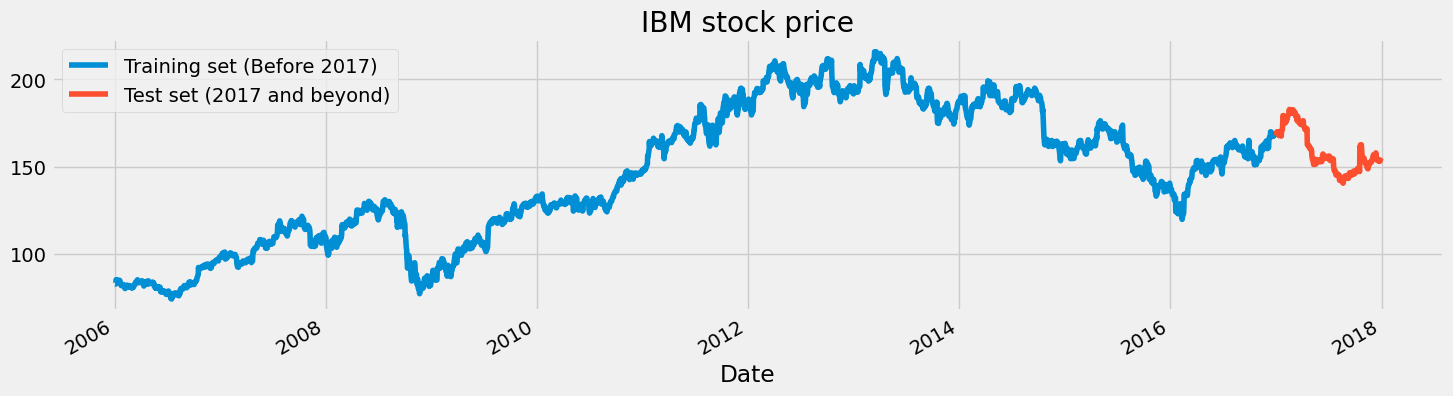

In [13]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [14]:
#scale data
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)

In [16]:
X_train = []
y_train = []
for i in range(60,2769):
    #the input will be these 60 states, whereas the label is the actual next state
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

(2709, 60, 1)

In [19]:
regressor = Sequential()
#output is 50 and returns sequence rather than last output
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2)) #dropout 
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1)) #dense 

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

2023-02-05 22:28:30.263673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
85/85 [==============================] - 6s 42ms/step - loss: 0.0208
Epoch 2/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0099
Epoch 3/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0078
Epoch 4/50
85/85 [==============================] - 4s 42ms/step - loss: 0.0068
Epoch 5/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0062
Epoch 6/50
85/85 [==============================] - 4s 48ms/step - loss: 0.0057
Epoch 7/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0050
Epoch 8/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0049
Epoch 9/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0045
Epoch 10/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0043
Epoch 11/50
85/85 [==============================] - 4s 44ms/step - loss: 0.0035
Epoch 12/50
85/85 [==============================] - 4s 42ms/step - loss: 0.0036
Epoch 13/50
85/85 [==================

In [21]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [22]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 15ms/step


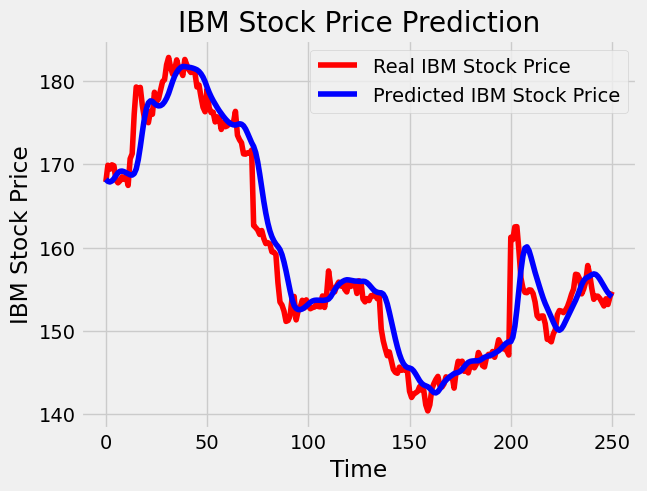

In [23]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [24]:
return_rmse(test_set,predicted_stock_price)

RMSE is 3.015303766956517
